The recommended dataset for this code is available here: https://grouplens.org/datasets/movielens/100k/

In [0]:
import numpy as np
import pandas as pd

In [0]:
column_names = ['User', 'Movies', 'rating', 'timestamp']
ratings = pd.read_csv('...', sep='\t', names=column_names)   # Path to downloaded file

In [0]:
ratings = ratings[ratings['rating']>3]
ratings = ratings.sort_values(by='timestamp')
ratings.reset_index(inplace=True)
ratings = ratings.drop(['index'],axis=1)
ratings.head()

In [0]:
user_movie_count = ratings.groupby('User').agg({'Movies':'nunique'}).reset_index()
user_movie_count.head()

In [0]:
user_movie_count.columns = ['User','User_Movie_count']

In [0]:
ratings2 = ratings.merge(user_movie_count,on='User',how='inner')
ratings2.head()

In [0]:
movie_count = ratings2[ratings2['User_Movie_count']>5]
movie_count = movie_count.sort_values('timestamp')
movie_count.reset_index(inplace=True)
movie_count = movie_count.drop(['index'],axis=1)
movie_count.head()

In [0]:
ratings = movie_count
users = ratings.User.unique()
movies = ratings.Movies.unique()
userid2idx = {o:i for i,o in enumerate(users)}
moviesid2idx = {o:i for i,o in enumerate(movies)}
idx2userid = {i:o for i,o in enumerate(users)}
idx2moviesid = {i:o for i,o in enumerate(movies)}

In [0]:
l = list(moviesid2idx.keys())
print(len(l))
set([x for x in l if l.count(x) > 1])

In [0]:
ratings['Movies2'] = ratings.Movies.apply(lambda x: moviesid2idx[x])
ratings['User2'] = ratings.User.apply(lambda x: userid2idx[x])
ratings.describe()

In [0]:
user_list = movie_count['User2'].unique()

In [0]:
x = []
y = []
for i in range(len(user_list)):
  if(i%100 == 0):
    print(i)
  total_user_movies = movie_count[movie_count['User2']==user_list[i]].copy()
  total_user_movies.reset_index(inplace=True)
  total_user_movies = total_user_movies.drop(['index'],axis=1)
  #print(total_user_movies.shape[0])
  for j in range(total_user_movies.shape[0]-6):
    x.append(total_user_movies.loc[j:(j+4),'Movies2'].tolist())
    y.append(total_user_movies.loc[(j+5),'Movies2'].tolist())

0
100
200
300
400
500
600
700
800
900


In [0]:
max(x)

[1446, 476, 427, 29, 1010]

In [0]:
src_vocab = ratings['Movies2'].nunique()
n_units = 32
src_timesteps = 5
tar_vocab = len(set(y))

In [0]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Bidirectional

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Embedding(src_vocab, n_units, input_length=src_timesteps))
model.add((LSTM(100)))
model.add(Dense(1000,activation='relu'))
model.add(Dense(max(y)+1,activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 32)             46304     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_2 (Dense)              (None, 1447)              1448447   
Total params: 1,648,951
Trainable params: 1,648,951
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.utils import to_categorical

In [0]:
max(y)

1446

In [0]:
y2 = to_categorical(y, num_classes = max(y)+1)

In [0]:
y2.shape

(49737, 1447)

In [0]:
from keras.optimizers import Adam
adam = Adam(lr=0.0001)

In [0]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['acc'])

In [0]:
trainX = np.array(x[:40000])
testX = np.array(x[40000:])
trainY = np.array(y2[:40000])
testY = np.array(y2[40000:])

In [0]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(40000, 5) (40000, 1447) (9737, 5) (9737, 1447)


In [0]:
model.fit(trainX, trainY, epochs=5, batch_size=32, validation_data=(testX, testY), verbose = 1)

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 9737 samples
Epoch 1/5
40000/40000 [==============================] - 36s 893us/step - loss: 6.5870 - acc: 0.0070 - val_loss: 6.5420 - val_acc: 0.0085
Epoch 2/5
40000/40000 [==============================] - 34s 853us/step - loss: 6.4031 - acc: 0.0074 - val_loss: 6.5275 - val_acc: 0.0066
Epoch 3/5
40000/40000 [==============================] - 34s 851us/step - loss: 6.3787 - acc: 0.0079 - val_loss: 6.4809 - val_acc: 0.0086
Epoch 4/5
40000/40000 [==============================] - 34s 839us/step - loss: 6.2840 - acc: 0.0098 - val_loss: 6.3236 - val_acc: 0.0109
Epoch 5/5
40000/40000 [==============================] - 34s 842us/step - loss: 6.1454 - acc: 0.0116 - val_loss: 6.2125 - val_acc: 0.0116


In [0]:
np.argmax(reversed(np.argsort(model.predict(testX[0].reshape(1,5)),axis=1)==213))

0

In [0]:
np.argmax(np.argsort(pred[i])[::-1]==np.argmax(testY[i]))

124

In [0]:
pred = model.predict(testX)

In [0]:
count = 0
for i in range(testX.shape[0]):
  rank = np.argmax(np.argsort(pred[i])[::-1]==np.argmax(testY[i]))
  if rank<12:
    count+=1

In [0]:
count/testX.shape[0]

0.10393344972784226

In [0]:
historically_watched = []
x = []
y = []
for i in range(len(user_list)):
  if(i%100 == 0):
    print(i)
  total_user_movies = movie_count[movie_count['User2']==user_list[i]].copy()
  total_user_movies.reset_index(inplace=True)
  total_user_movies = total_user_movies.drop(['index'],axis=1)
  for j in range(total_user_movies.shape[0]-6):
    historically_watched.append(total_user_movies.loc[0:(j+4),'Movies2'].tolist())
    x.append(total_user_movies.loc[j:(j+4),'Movies2'].tolist())
    y.append(total_user_movies.loc[(j+5),'Movies2'].tolist())

0
100
200
300
400
500
600
700
800
900


In [0]:
test_hist = x[40000:]
test_historically_watched = historically_watched[40000:]

In [0]:
testX.shape

(9737, 5)

In [0]:
pred.shape

(9737, 1447)

In [0]:
len(test_hist)

9737

In [0]:
for j in range(pred.shape[0]):
  if(j%100==0):
    print(j)
  for i in range(pred.shape[1]):
    pred[j][i]= np.where(i in test_historically_watched[j], 0 , pred[j][i])

In [0]:
count = 0
for i in range(testX.shape[0]):
  rank = np.argmax(np.argsort(pred[i])[::-1]==np.argmax(testY[i]))
  if rank<12:
    count+=1

In [0]:
count/testX.shape[0]

0.1260141727431447

In [0]:
np.mean(pred[:,0])

0.0010644234

In [0]:
!pip install gensim

In [0]:
import gensim

In [0]:
user_movies = []
for i in range(len(movie_list)):
  if(i%100 == 0):
    print(i)
  total_user_movies = movie_count[movie_count['Movies2']==movie_list[i]].copy()
  total_user_movies.reset_index(inplace=True)
  total_user_movies = total_user_movies.drop(['index'],axis=1)
  total_user_movies['User3'] = total_user_movies['User2'].astype(str)
  user_movies.append(total_user_movies['User3'].tolist())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [0]:
movie_list = movie_count['Movies2'].unique()

In [0]:
user_list = movie_count['User2'].unique()

In [0]:
user_movies = []
for i in range(len(user_list)):
  total_user_movies = movie_count[movie_count['User2']==user_list[i]].copy()
  total_user_movies.reset_index(inplace=True)
  total_user_movies = total_user_movies.drop(['index'],axis=1)
  total_user_movies['Movies3'] = total_user_movies['Movies2'].astype(str)
  user_movies.append(total_user_movies['Movies3'].tolist())

In [0]:
len(user_movies)

934

In [0]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(user_movies,size=100,window=5,min_count=5, iter = 500)

In [0]:
w2v_model.wv.syn0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(1008, 100)

In [0]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_img_label = tsne_model.fit_transform(w2v_model.wv.syn0)
tsne_df = pd.DataFrame(tsne_img_label, columns=['x', 'y'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1008 samples in 0.007s...
[t-SNE] Computed neighbors for 1008 samples in 0.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1008
[t-SNE] Computed conditional probabilities for sample 1008 / 1008
[t-SNE] Mean sigma: 6.362085
[t-SNE] KL divergence after 250 iterations with early exaggeration: 124.444023
[t-SNE] KL divergence after 1000 iterations: 2.253800


In [0]:
tsne_df['image_label'] = list(w2v_model.wv.vocab.keys())

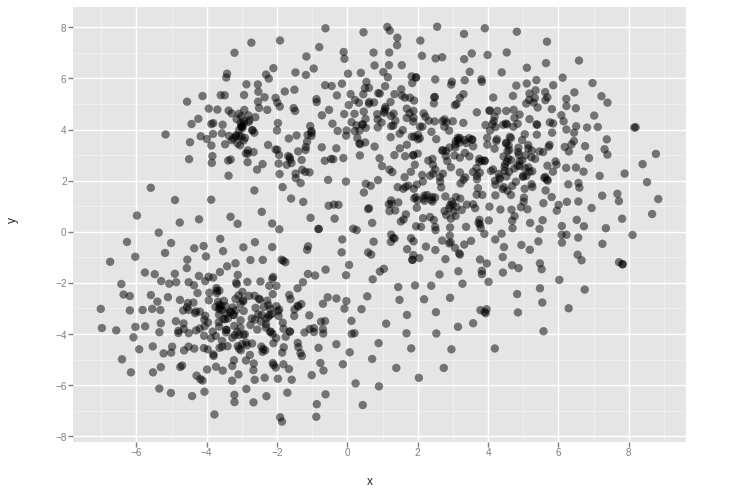

<ggplot: (-9223363276564716263)>

In [0]:
from ggplot import *
chart = ggplot(tsne_df, aes(x='x', y='y'))+geom_point(size=70,alpha=0.5)
chart

In [0]:
!pip install ggplot

    100% |████████████████████████████████| 2.2MB 9.0MB/s 


In [0]:
idx2movie = pd.DataFrame([idx2moviesid.keys(), idx2moviesid.values()]).T
idx2movie.columns = ['image_label','movieId']
idx2movie.head()

In [0]:
tsne_df['image_label'] = tsne_df['image_label'].astype(int)

In [0]:
tsne_df.head()

In [0]:
tsne_df2 = pd.merge(tsne_df, idx2movie, on='image_label', how='right')
tsne_df2.head()

In [0]:
movies = pd.read_csv('...', sep='|',encoding='latin1',header=None)  # Path to movies file

In [0]:
tsne_df3 = pd.merge(tsne_df2, movies, left_on='movieId', right_on = 0, how='inner')

In [0]:
tsne_df3.head()

In [0]:
tsne_df3.shape

(1447, 28)

In [0]:
tsne_df4 = tsne_df3.drop([2,3,4],axis=1)

In [0]:
tsne_df4.rename(columns={1:'movie_name'}, inplace=True)

In [0]:
tsne_df4.describe()

In [0]:
tsne_df4.shape

(1447, 25)

In [0]:
from sklearn.cluster import KMeans

In [0]:
tsne_df5 = tsne_df4.loc[~np.isnan(tsne_df4['x']),]

In [0]:
X = tsne_df5.loc[:,['x','y']]

In [0]:
inertia = []
for i in range(10):
  km = KMeans((i+1)*10)
  km.fit(X)
  inertia.append(km.inertia_)
  print(i)

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Inertia')

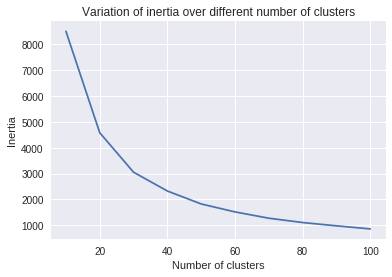

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot((np.arange(10)+1)*10,inertia)
plt.title('Variation of inertia over different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [0]:
km = KMeans(40)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=40, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [0]:
tsne_df5['cluster_label'] = km.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
tsne_df5[tsne_df5['cluster_label']==0].head()

In [0]:
movie_cluster_id = tsne_df5[['image_label','cluster_label']]

In [0]:
pred = model.predict(testX)

In [0]:
pred.shape

(9737, 1447)

In [0]:
for j in range(pred.shape[0]):
  if(j%1000==0):
    print(j)
  for i in range(pred.shape[1]):
    pred[j][i]= np.where(i in test_historically_watched[j], 0 , pred[j][i])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [0]:
pred.shape

(9737, 1447)

In [0]:
movie_cluster_id.head()

In [0]:
list(movie_cluster_id['image_label'])

In [0]:
pred[0,list(movie_cluster_id['image_label'])]

array([2.6576780e-03, 1.5723570e-03, 0.0000000e+00, ..., 2.3026960e-05,
       1.1034694e-05, 4.5954261e-05], dtype=float32)

In [0]:
count = 0
for j in range(pred.shape[0]):
  if(j%500==0):
    print(j)
  t = movie_cluster_id.copy()
  t['pred']=pred[j,list(movie_cluster_id['image_label'])]
  t2= t.sort_values(by='pred',ascending=False).groupby('cluster_label').first().reset_index()
  #xx2 = t2.groupby('cluster_label').head(1).reset_index()
  t3 = t2.sort_values(by='pred',ascending=False).reset_index()
  final_top_preds = t3.loc[:11]['image_label'].values
  if (np.argmax(testY[j]) in final_top_preds):
    count+=1
    

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [0]:
count/testX.shape[0]

0.13546266817294855